In [4]:
!pip install lifelines

In [5]:
import numpy as np  # Importing NumPy for numerical operations
import pandas as pd  # Importing Pandas for data manipulation
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
from lifelines import KaplanMeierFitter  # Importing Kaplan-Meier estimator from lifelines
from lifelines.statistics import logrank_test  # Importing log-rank test for survival comparison


In [6]:
from google.colab import files
uploaded=files.upload()

Saving GBM_patient_data.csv to GBM_patient_data.csv


In [7]:
pd_data=pd.read_csv('/content/GBM_patient_data.csv')
pd_data.head()

,age (years),"sex (0=Female, 1=Male)","MGMT_promotor_methylated (0=WT, 1=Methylated)","IDH_mutant (0=WT, 1=Mutant)","treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)","event (1=event occurred, 0=censored)",survival_time (days)
0,64.967142,0,0,1,0,1,194.181664
1,58.617357,0,0,0,0,1,73.346847
2,66.476885,1,0,0,1,1,360.114365
3,75.230299,1,0,1,1,1,219.539143
4,57.658466,0,1,0,0,0,516.734029


In [9]:
pd_data_0=pd_data[pd_data['treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)']==0]
pd_data_1=pd_data[pd_data['treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)']==1]
pd_data_0.head()
# pd_data_1.head()



,age (years),"sex (0=Female, 1=Male)","MGMT_promotor_methylated (0=WT, 1=Methylated)","IDH_mutant (0=WT, 1=Mutant)","treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)","event (1=event occurred, 0=censored)",survival_time (days)
0,64.967142,0,0,1,0,1,194.181664
1,58.617357,0,0,0,0,1,73.346847
4,57.658466,0,1,0,0,0,516.734029
9,65.425600,1,0,0,0,1,166.110538
14,42.750822,0,0,1,0,1,309.066622


# **Fit KaplanMeier to both data**

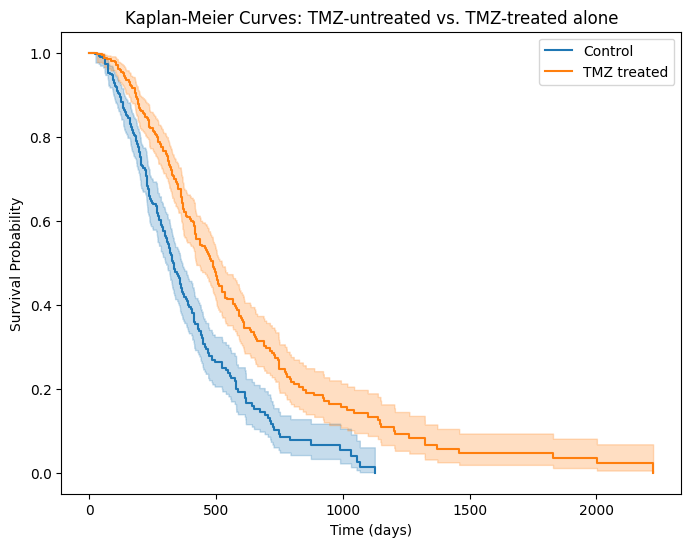

In [11]:
kmf0=KaplanMeierFitter()
kmf0.fit(durations=pd_data_0['survival_time (days)'],event_observed=pd_data_0['event (1=event occurred, 0=censored)'],label='Control')


kmf1=KaplanMeierFitter()
kmf1.fit(durations=pd_data_1['survival_time (days)'],event_observed=pd_data_1['event (1=event occurred, 0=censored)'],label='TMZ treated')

plt.figure(figsize=(8,6))

kmf0.plot_survival_function(ci_show=True)
kmf1.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Curves: TMZ-untreated vs. TMZ-treated alone")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()





# **Log-rank test to check how statistically different the two curves are**

In [12]:
from lifelines.statistics import logrank_test
results=logrank_test(pd_data_0['survival_time (days)'],
                     pd_data_1['survival_time (days)'],
                     pd_data_0['event (1=event occurred, 0=censored)'],
                     pd_data_1['event (1=event occurred, 0=censored)'])
print(f"P_value: {results.p_value}")

P_value: 9.274697389915403e-10


# **Fit the Cox Model**

In [13]:
# import coxfitter
from lifelines import CoxPHFitter

pd_data_cox = pd_data[pd_data['treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)'].isin([0, 1])].copy()
cph=CoxPHFitter()
cph.fit(
    pd_data_cox,
    duration_col='survival_time (days)',
    event_col='event (1=event occurred, 0=censored)'
    )
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 618 total observations, 187 right-censored observations>
             duration col = 'survival_time (days)'
                event col = 'event (1=event occurred, 0=censored)'
      baseline estimation = breslow
   number of observations = 618
number of events observed = 431
   partial log-likelihood = -2261.61
         time fit was run = 2025-03-20 13:29:39 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
age (years)                                                  0.03      1.03      0.01            0.02            0.04                1.02                1.04
sex (0=Female, 1=Male)                                       0.08      1.09      0.10           -0.11            0.27                0.90                1.31
MGMT_promotor_methylated (0=WT, 1=Methylated)               -0.92      0.40      0.11           -1.13           -0.70                0.32                0.49
IDH_mutant (0=WT, 1=Mutant)                                 -0.43      0.65      0.10           -0.63           -0.23                0.53                0.79
treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ) -0.73      0.48      0.10           -0.93           -0.53                0.39                0.59

                                                             cmp to     z      p  -log2(p)
covariate                                                                                 
age (years)                                                    0.00  5.68 <0.005     26.17
sex (0=Female, 1=Male)                                         0.00  0.83   0.40      1.31
MGMT_promotor_methylated (0=WT, 1=Methylated)                  0.00 -8.44 <0.005     54.83
IDH_mutant (0=WT, 1=Mutant)                                    0.00 -4.27 <0.005     15.64
treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)    0.00 -7.18 <0.005     40.35
---
Concordance = 0.66
Partial AIC = 4533.21
log-likelihood ratio test = 146.97 on 5 df
-log2(p) of ll-ratio test = 97.10

In [15]:
pd_data_cox['treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)'].unique()

array([0, 1])

# **Plot for cox model**

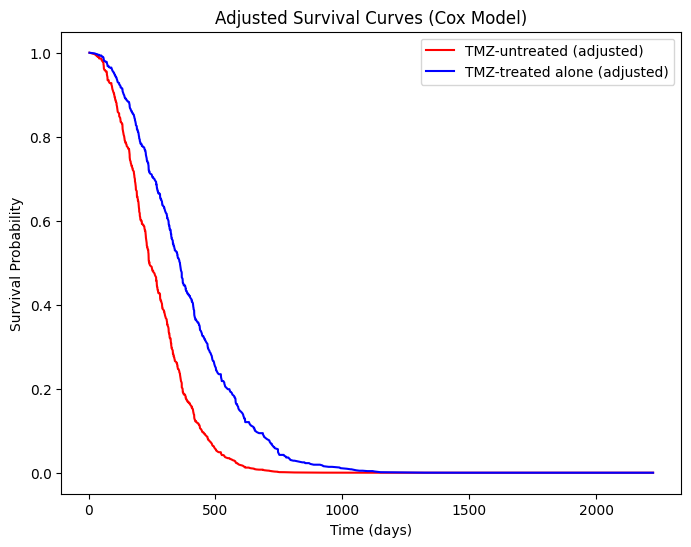

In [16]:
# we want the curves to primarily reflect the effects of treatment (TMZ vs no TMZ)
# there we use one group of other columns and average age
average_age=pd_data_cox['age (years)'].mean()
controls={
    'treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)':0,
    'age (years)':average_age,
    'sex (0=Female, 1=Male)':1, # male as reference
    'MGMT_promotor_methylated (0=WT, 1=Methylated)':0,
'IDH_mutant (0=WT, 1=Mutant)':0
}

tmz_treated={
    'treatment (0=TMZ-untreated, 1=TMZ-treated alone, 2=Mi1+TMZ)':1,
    'age (years)':average_age,
    'sex (0=Female, 1=Male)':1,
    'MGMT_promotor_methylated (0=WT, 1=Methylated)':0,
'IDH_mutant (0=WT, 1=Mutant)':0


}

df_controls=pd.DataFrame([controls])
df_tmz_treated=pd.DataFrame([tmz_treated])
survival_controls=cph.predict_survival_function(df_controls)
survival_tmz_treated=cph.predict_survival_function(df_tmz_treated)

plt.figure(figsize=(8,6))
plt.plot(survival_controls.index, survival_controls.iloc[:, 0], label='TMZ-untreated (adjusted)', color='red')
plt.plot(survival_tmz_treated.index, survival_tmz_treated.iloc[:, 0], label='TMZ-treated alone (adjusted)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.title('Adjusted Survival Curves (Cox Model)')
plt.legend()
plt.show()
